<a href="https://colab.research.google.com/github/mohamed-ben-lboukht/nn_from_scratch/blob/main/nn_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#building neural network  from scratch without using torch or tensorflow


In [70]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch as tr
import graphviz
from IPython.display import display

In [71]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value={self.data}"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def sigmoid(self):
    x = self.data
    t = 1/(math.exp(-2*x) + 1)
    out = Value(t, (self, ), 'sigm')

    def _backward():
      self.grad += t * (1 - t) * out.grad
    out._backward = _backward

    return out
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def relu(self):
    x = self.data
    t = max(0, x)  # ReLU function
    out = Value(t, (self,), 'relu')

    def _backward():
        self.grad += (1 if x > 0 else 0) * out.grad  # Derivative of ReLU: 1 if x > 0, else 0

    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [72]:
a = Value(10)
b = Value(20)
c = a - b
c*=12


In [73]:
class Neurone:
  def __init__(self, nin):
    self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(np.random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]






In [74]:
x = [2.0, 3.0, -1.0]
n = Neurone(3)
n(x)

Value=-0.9144563021394371

In [75]:
class Layer():
  def __init__(self, nin, nout):
    self.neurons = [Neurone(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [132]:
class nn():
  def __init__(self,nin,nouts):
    size = [nin] + nouts
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]
    self.loss = None
    self._params = self.parameters()
    self.size = size
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0.0

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  def train(self,xs,ys,epochs=10,alpha=0.01):
    for k in range(epochs):
      # forward pass
      ypred = [n(x) for x in xs]
      loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

      # backward pass
      self.zero_grad()
      loss.backward()

      # update
      for p in n.parameters():
        p.data += -alpha * p.grad

      print(k, loss.data)
      self.loss = loss.data


  def __repr__(self):
    dot = graphviz.Digraph(format='png')
    dot.attr(rankdir='LR')  # Left to Right layout

    # Add input layer nodes
    for i in range(self.size[0]):
        dot.node(f'I{i}', shape='circle', color='red', label=f"x{i}")

    # Keep track of neuron indices per layer
    neuron_count = 0

    # Add hidden and output layers
    for layer_idx, layer in enumerate(self.layers):
        for j, neuron in enumerate(layer.neurons):  # Iterate neurons in the layer
            node_id = f'L{layer_idx + 1}_{j}'
            color = 'blue' if layer_idx < len(self.layers) - 1 else 'green'
            neuron_label = f"h{neuron_count}" if layer_idx < len(self.layers) - 1 else f"y{j}"
            neuron_count += 1  # Ensure proper ranking

            # Include bias in the label
            bias_value = round(neuron.b.data, 2)
            dot.node(node_id, shape='circle', color=color, label=f"{neuron_label}\n(b={bias_value})")

            # Connect previous layer to current layer with real weights
            for k, weight in enumerate(neuron.w):  # Get each neuron's weights
                prev_id = f'L{layer_idx}_{k}' if layer_idx > 0 else f'I{k}'
                weight_value = round(weight.data, 2)  # Extract real weight value
                dot.edge(prev_id, node_id, label=f"W{k}{j}={weight_value}")  # Show real weight

    # Labels for clarity
    dot.node("", shape="plaintext", color="red", fontsize="14")
    dot.edge("", "I0", style="invis")

    dot.node("", shape="plaintext", color="blue", fontsize="14")
    dot.edge("", f"L1_0", style="invis")

    dot.node("", shape="plaintext", color="green", fontsize="14")
    dot.edge("", f"L{len(self.size) - 1}_0", style="invis")

    display(dot)

    return "Neural network visualization displayed."







In [133]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


n = nn(3, [4, 4, 1])
n.train(xs, ys,alpha=0.05)

0 2.766769371362662
1 1.0765167595207732
2 0.5997289792988432
3 0.3964448440498987
4 0.2884003794989584
5 0.22333567550416306
6 0.1806106741111237
7 0.15072840605564897
8 0.12881049680201803
9 0.1121297751769512


In [134]:
n([2.0, 3.0, -1.0])

Value=0.8225878334709512

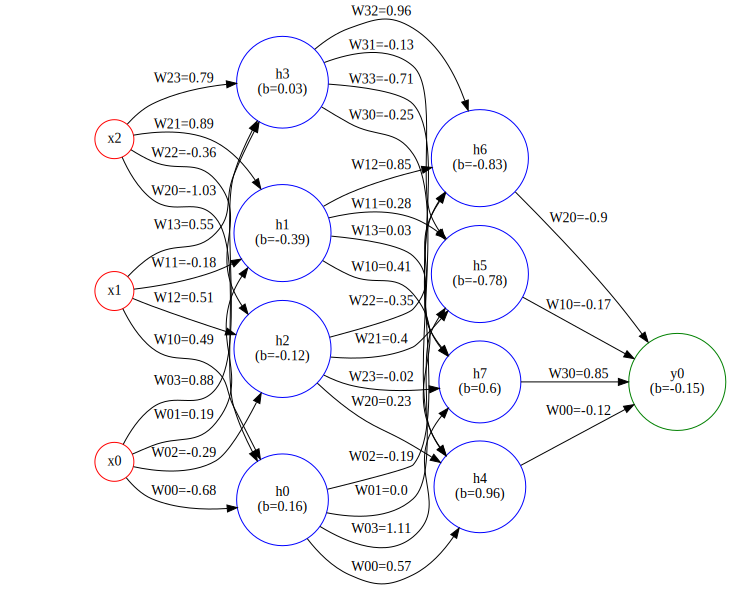

Neural network visualization displayed.

In [135]:
n

#let's use it with a real data